# Recurrent Neural Networks

In our [previous MLP experiment](./03-mlp.ipynb), we saw that a neural network could extract more from averaged word embeddings than a simple Logistic Regression. However, averaging throws away crucial information - the order of words in a sentence.

This time, we are going to dive deeper into **recurrent neural networks**. They are specifically designed to process sequences, remembering context and understanding how word order contributes to meaning. Let's see if harnessing this sequential power can push our accuracy even further.

## Data Preparation

In [1]:
from datasets import load_dataset
import numpy as np

train, test = load_dataset('stanfordnlp/imdb', split=['train', 'test'])
class_names = train.features['label'].names

x_train = np.array(train['text'])
y_train = np.array(train['label'])
x_test = np.array(test['text'])
y_test = np.array(test['label'])

## Data Encoding

In our previous notebook, we simply tokenized text and then immediately squashed it into the averaged word vectors. Our new recurrent pipeline needs to be a bit more complicated.

This time, we would simply **tokenize** our sentences first - without trying to vectorize them. We might limit the vocabulary, making it more robust and accurate representation of frequently occurring words by filtering out rare or noisy terms.

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab, oov_token='[OOV]')

tokenizer.fit_on_texts(x_train)
display(tokenizer.texts_to_sequences(['Hello World']))

[[4804, 180]]

Next, we need to **pad** our sequences. Most neural networks require input sequences to be of a uniform length. Since our sentences naturally vary, we need to bring them to the same length.

This involves either truncating longer sequences or adding special tokens (usually zeros) to shorter sequences until they all reach a predetermined maximum length. Let's do a small research to determine how long our sequences usually are.

In [3]:
import matplotlib.pyplot as plt
text_lengths = train.to_pandas()['text'].apply(lambda x: len(x.split()))
display(text_lengths.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]))

count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
95%        598.000000
99%        913.000000
max       2470.000000
Name: text, dtype: float64

Taking the top quartile length seems to be a reasonable choice here.

In [4]:
from tensorflow.keras.utils import pad_sequences

max_seq = 284
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_seq)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_seq)

display(x_train)
display(x_train.shape)

array([[   5,   30,    2, ...,    5,    4,  112],
       [   0,    0,    0, ...,    5, 5075, 2347],
       [   0,    0,    0, ..., 1785,    8,    8],
       ...,
       [   0,    0,    0, ...,  278,    4,    1],
       [1600,    1,  762, ...,   17,    2, 9207],
       [   0,    0,    0, ...,    1,   24, 3573]], dtype=int32)

(25000, 284)

## Embedding Layer

Finally, we need to transform these padded sequences into some meaningful representation that captures their semantic relationships. That's where the **embedding layer** comes in. To build it, we may utilize our existing pre-trained model.

In [5]:
from os import path
from huggingface_hub import snapshot_download
from gensim.models import KeyedVectors

model_path = path.join(snapshot_download('fse/word2vec-google-news-300'), 'word2vec-google-news-300.model')
wv = KeyedVectors.load(model_path)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Think of it as some sort of a **lookup table** - for each token in our sequence, the embedding layer looks up its corresponding dense vector. This helps our neural network to capture not some random indexes, but the *semantic* meaning of words.

In [6]:
embedding_matrix_shape = (max_vocab, wv.vector_size)
embedding_matrix = np.zeros(shape=embedding_matrix_shape)
for word, index in tokenizer.word_index.items():
    if index < max_vocab:
        if word in wv:
            embedding_matrix[index] = wv.get_vector(word)
        else:
            embedding_matrix[index] = np.zeros(wv.vector_size)

## Building and Training the Model

Here comes the most interesting part. 

With our text now represented as sequences of dense semantic vectors (thanks to the embedding layer), we can introduce the star of this experiment - the **Gated Recurrent Unit (GRU)** layer. Unlike a simple dense layer that processes all its inputs at once, a GRU layer processes each vector in our sequence one at a time. Internally, each GRU unit contains two **gates** – an update gate, and a reset gate. 

These gates learn to control the flow of information, deciding what to remember from previous steps, what to discard, and what new information from the current word's vector is important enough to update its hidden memory, allowing it to capture *context* and *dependencies* across the entire sequence.

We may also make the recurrent layer **bidirectional**, wrapping it in a special helper function - this will allow the network to capture information from both past and future time steps, leading to a more comprehensive understanding of the sequence.

In [7]:
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras import layers, Sequential

num_classes = len(class_names)
set_random_seed(0)

model = Sequential([
    layers.Input(shape=(max_seq,)),
    layers.Embedding(
        weights=[embedding_matrix],
        input_dim=embedding_matrix_shape[0],
        output_dim=embedding_matrix_shape[1],
        trainable=False,
    ),
    layers.SpatialDropout1D(0.2),
    layers.Bidirectional(layers.GRU(128, dropout=0.3)),
    layers.Dropout(0.6),
    layers.Dense(num_classes, activation='softmax'),
])

display(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 284, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 284, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       330,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,330,754 (24.15 MB)

 Trainable params: 330,754 (1.26 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

None

Before we start the training, we might tweak a few more things. Changing the optimizer learning rate may be a good idea - the default one might be too high when using pre-trained embeddings.

In [8]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

We might also use our early stopping callback again.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Finally, let's compile and train our final model. This time we might start using the GPU - our model is finally complex enough to leverage the parallelism it offers to speed up the training process.

In [10]:
from tensorflow import device
with device('/GPU'):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=50, batch_size=64, callbacks=[earlystop], validation_split=0.2) 

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.6692 - loss: 0.6040 - val_accuracy: 0.6120 - val_loss: 0.7549
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.8129 - loss: 0.4204 - val_accuracy: 0.8756 - val_loss: 0.3363
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.8539 - loss: 0.3451 - val_accuracy: 0.8772 - val_loss: 0.3217
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.8655 - loss: 0.3222 - val_accuracy: 0.8454 - val_loss: 0.3880
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.8717 - loss: 0.3038 - val_accuracy: 0.8658 - val_loss: 0.3443
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.8785 - loss: 0.2909 - val_accuracy: 0.8832 - val_loss: 0.3025
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.8874 - loss: 0.2760 - val_accuracy: 0.8906 - val_loss: 0.2834
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.8926 - loss: 0.2621 - 

## Result

In [11]:
from sklearn.metrics import classification_report
with device('/GPU'):
    y_pred_values = model.predict(x_test, verbose=False)
    y_pred_labels = np.argmax(y_pred_values, axis=1)
    print(classification_report(y_test, y_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

         neg       0.91      0.88      0.90     12500
         pos       0.89      0.92      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



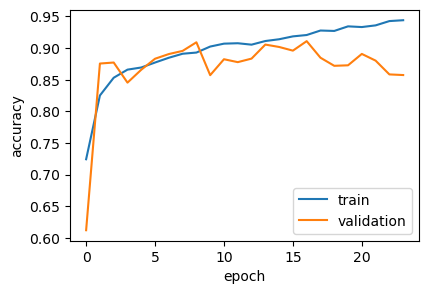

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.5, 3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

## Conclusion

We achieved a final accuracy of **90%**, finally reaching the original **TF-IDF** linear model level. The learning curve is still a bit wonky, but it looks much, much healthier now.

This proves the value of sequence-aware models over simple embedding averaging for this kind of task, performing competitively with the heavily optimized linear approach. Further improvements would require exploring more advanced architectures like transformers.